In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import scipy
import seaborn as sns

from allen_v1dd.client import OPhysClient, EMClient
from allen_v1dd.stimulus_analysis import DriftingGratings
import allen_v1dd.stimulus_analysis.analysis_tools as at
at.set_stylesheet()

%load_ext autoreload
%autoreload 2

/Users/chase/Desktop/MindScope/allen_v1dd/src/allen_v1dd/stimulus_analysis/drifting_gratings.py:8: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
em_client = EMClient()

/opt/anaconda3/envs/v1dd/lib/python3.10/site-packages/standard_transform/datasets.py:24: UserWarning: Optimal rotation is not uniquely or poorly defined for the given sets of vectors.
  rot, _ = R.align_vectors(np.array([[0, 1, 0]]), [up])


In [3]:
metrics = at.load_roi_metrics(remove_duplicates=False)

In [4]:
coreg_table = em_client.get_coregistration_table()
coreg_table.drop_duplicates("pt_root_id", inplace=True)
coreg_table.head()

/Users/chase/Desktop/MindScope/allen_v1dd/src/allen_v1dd/client/em_client.py:68: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if res == "mixed_resolutions":


,id_ref,created_ref,valid_ref,volume,pt_supervoxel_id,pt_root_id,id,created,valid,target_id,session,scan_idx,unit_id,field,residual,score,pt_position,bb_start_position,bb_end_position,roi,position_microns,axon_proofreading_status,axon_proofreading_complete,dendrite_proofreading_status,dendrite_proofreading_complete
0,277703,2022-02-04 06:24:15.742387+00:00,t,279.238104,92055099945612303,864691132710145793,1,2023-02-14 16:50:14.491563+00:00,t,277703,1,3,14,2,NaN,NaN,"[794469, 608850, 265500]","[789813, 605047, 28149]","[799901, 612885, 29027]",M409828_13_3_14,"[797.7329658575621, 268.4703958902916, 92.8290...",submitted,True,not_started,False
1,277515,2022-02-04 06:26:06.653170+00:00,t,329.847534,93180175218565442,864691132760377194,2,2023-02-14 16:50:14.492369+00:00,t,277515,1,3,60,0,NaN,NaN,"[834898, 578974, 258390]","[829699, 575016, 27320]","[840253, 582931, 28368]",M409828_13_1_60,"[838.0087061146714, 237.58057806602417, 93.975...",submitted,True,not_started,False
2,277213,2022-02-04 06:30:33.362739+00:00,t,313.577943,91843581329183083,864691132720617684,3,2023-02-14 16:50:14.493215+00:00,t,277213,1,3,30,1,NaN,NaN,"[786864, 593718, 243945]","[782441, 588906, 25792]","[791287, 598451, 26699]",M409828_13_2_30,"[790.0267659909371, 248.15872319569212, 76.111...",submitted,True,not_started,False
3,293528,2022-02-04 06:22:30.509490+00:00,t,332.374686,91070624654826905,864691132741334425,4,2023-02-14 16:50:14.494034+00:00,t,293528,1,3,119,4,NaN,NaN,"[759859, 632673, 243810]","[755436, 627939, 25734]","[764515, 637174, 26753]",M409828_13_5_119,"[763.2087486129211, 285.7899063229709, 65.5534...",submitted,True,submitted,True
4,277969,2022-02-04 06:21:54.350553+00:00,t,313.560871,92547337557612090,864691132771662867,5,2023-02-14 16:50:14.494820+00:00,t,277969,1,3,271,1,NaN,NaN,"[812705, 597132, 270405]","[808514, 592554, 28683]","[817050, 601866, 29619]",M409828_13_2_271,"[815.9190761795869, 258.40239635218177, 100.69...",submitted,True,not_started,False


In [190]:
# Add relevant metrics columns to coreg table
coreg_table = coreg_table.merge(metrics[["dgw_is_responsive", "dgf_is_responsive", "dgw_pref_dir", "dgw_pref_ori", "ssi"]], how="left", left_on="roi", right_index=True)
coreg_table.head()

,id_ref,created_ref,valid_ref,volume,pt_supervoxel_id,pt_root_id,id,created,valid,target_id,...,position_microns,axon_proofreading_status,axon_proofreading_complete,dendrite_proofreading_status,dendrite_proofreading_complete,dgw_is_responsive,dgf_is_responsive,dgw_pref_dir,dgw_pref_ori,ssi
0,277703,2022-02-04 06:24:15.742387+00:00,t,279.238104,92055099945612303,864691132710145793,1,2023-02-14 16:50:14.491563+00:00,t,277703,...,"[-112.56958689132787, 379.9149376229235, -318....",submitted,True,not_started,False,False,True,90.0,90.0,-0.035780
1,277515,2022-02-04 06:26:06.653170+00:00,t,329.847534,93180175218565442,864691132760377194,2,2023-02-14 16:50:14.492369+00:00,t,277515,...,"[-72.29384663421858, 349.0251197986561, -317.5...",submitted,True,not_started,False,False,False,0.0,0.0,0.315936
2,277213,2022-02-04 06:30:33.362739+00:00,t,313.577943,91843581329183083,864691132720617684,3,2023-02-14 16:50:14.493215+00:00,t,277213,...,"[-120.275786757953, 359.60326492832405, -335.4...",submitted,True,not_started,False,True,True,150.0,150.0,0.928388
3,293528,2022-02-04 06:22:30.509490+00:00,t,332.374686,91070624654826905,864691132741334425,4,2023-02-14 16:50:14.494034+00:00,t,293528,...,"[-147.09380413596892, 397.23444805560285, -345...",submitted,True,submitted,True,False,False,180.0,0.0,0.822290
4,277969,2022-02-04 06:21:54.350553+00:00,t,313.560871,92547337557612090,864691132771662867,5,2023-02-14 16:50:14.494820+00:00,t,277969,...,"[-94.38347656930308, 369.84693808481364, -310....",submitted,True,not_started,False,True,False,90.0,90.0,0.323559


In [191]:
coreg_responsive = coreg_table[coreg_table["dgw_is_responsive"]]
len(coreg_responsive)

16

In [19]:
# Load dendritic synapses
all_den_syn = em_client.get_dendritic_synapses(coreg_responsive.pt_root_id.values)
all_den_syn

,index,id,created,superceded_id,valid,size,pre_pt_supervoxel_id,pre_pt_root_id,post_pt_supervoxel_id,post_pt_root_id,pre_pt_position,post_pt_position,ctr_pt_position,synapse_position_microns,pre_soma_position_voxels,pre_soma_position_microns,post_soma_position_voxels,post_soma_position_microns
0,0,422785658,2021-11-19 01:52:24.346275+00:00,NaN,t,2212,93814868372772310,864691132821072303,93814868372773278,864691132958399079,"[88375, 64814, 6258]","[88371, 64861, 6263]","[88374, 64821, 6264]","[-49.721531513314346, 403.5358792013583, -308....",None,None,"[927553, 616377, 287280]","[20.577884736687643, 392.3348788111006, -299.7..."
1,1,475404906,2021-11-19 06:32:06.481273+00:00,NaN,t,638,95925587100660199,864691132010283734,95925587100645222,864691132958399079,"[96007, 63568, 6214]","[95946, 63557, 6199]","[95969, 63553, 6214]","[23.690557160289725, 390.2121626782586, -307.7...",None,None,"[927553, 616377, 287280]","[20.577884736687643, 392.3348788111006, -299.7..."
2,2,445008264,2021-11-19 03:18:23.734454+00:00,NaN,t,2185,95150637561839625,864691132570817439,95150637561836866,864691132958399079,"[93135, 60250, 6504]","[93131, 60228, 6497]","[93127, 60244, 6501]","[-3.7516052064921244, 362.8252638009206, -286....",None,None,"[927553, 616377, 287280]","[20.577884736687643, 392.3348788111006, -299.7..."
3,3,483346869,2021-11-19 05:58:04.620231+00:00,NaN,t,2311,96622883564352663,864691132532796900,96622883564359401,864691132958399079,"[98585, 39554, 6033]","[98594, 39607, 6029]","[98608, 39563, 6037]","[48.251464291394456, 164.20247106467687, -252....",None,None,"[927553, 616377, 287280]","[20.577884736687643, 392.3348788111006, -299.7..."
4,4,463089276,2021-11-19 05:27:11.915243+00:00,NaN,t,1014,95290619135618258,864691132480968522,95290550416151406,864691132958399079,"[93710, 57244, 6216]","[93698, 57174, 6217]","[93697, 57210, 6217]","[1.589362136177253, 330.88271580844093, -290.4...",None,None,"[927553, 616377, 287280]","[20.577884736687643, 392.3348788111006, -299.7..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41266,41656,457836921,2021-11-19 04:31:00.234463+00:00,NaN,t,1331,95292268738840360,864691132544274740,95292268738838143,864691132787759441,"[93783, 63540, 8959]","[93826, 63558, 8964]","[93812, 63549, 8962]","[3.292649335501366, 423.6305179145001, -187.91...",None,None,"[837692, 637872, 330660]","[-69.12111015893834, 425.1046289807488, -263.7..."
41267,41657,408864088,2021-11-19 04:31:50.827876+00:00,NaN,t,407,92898975321030716,864691132745092789,92899044040498019,864691132787759441,"[85102, 60764, 7257]","[85093, 60811, 7251]","[85108, 60798, 7253]","[-81.64690721251594, 377.744554178557, -255.05...",None,None,"[837692, 637872, 330660]","[-69.12111015893834, 425.1046289807488, -263.7..."
41268,41658,386179406,2021-11-19 04:32:59.269306+00:00,NaN,t,220,92197830365895309,864691132833156099,92197830365893057,864691132787759441,"[82495, 70038, 6409]","[82473, 70035, 6404]","[82473, 70040, 6406]","[-106.68226792655688, 453.8747436715448, -315....",None,None,"[837692, 637872, 330660]","[-69.12111015893834, 425.1046289807488, -263.7..."
41269,41659,387148512,2021-11-19 01:14:09.397666+00:00,NaN,t,348,92540465676993237,864691132919688203,92540465677001396,864691132787759441,"[83882, 35825, 6530]","[83880, 35769, 6536]","[83886, 35798, 6535]","[-94.62071569079475, 135.15060944733165, -221....","[831096, 727733, 308745]","[-75.31525640160696, 505.8516668864581, -308.8...","[837692, 637872, 330660]","[-69.12111015893834, 425.1046289807488, -263.7..."


864691132829082994: 193/3136 (6.2%)
864691132687688330: 38/830 (4.6%)
864691132972662837: 80/1947 (4.1%)
864691132787759441: 94/1067 (8.8%)
864691132834513288: 195/3303 (5.9%)
864691132656684760: 71/1487 (4.8%)
864691132924264745: 221/3934 (5.6%)
864691132771662867: 223/2746 (8.1%)
864691132656860120: 195/2946 (6.6%)
864691132834400136: 117/1532 (7.6%)
864691132594653239: 246/3440 (7.2%)
864691132958399079: 147/2323 (6.3%)
864691132657738615: 123/2971 (4.1%)
864691132734110231: 243/3710 (6.5%)
864691132720617684: 160/3189 (5.0%)
864691132835126165: 160/2710 (5.9%)


(0.0, 1.0447496624783021)

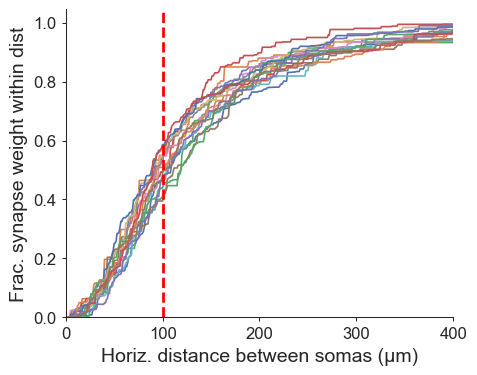

In [135]:
horiz_dist = lambda a, b: np.nan if a is None or b is None else np.linalg.norm(a[[0, 2]] - b[[0, 2]])
all_den_syn["soma_soma_horiz_dist"] = all_den_syn.apply(lambda row: horiz_dist(row["pre_soma_position_microns"], row["post_soma_position_microns"]), axis=1)

horizontal_radius = 100 # microns; "local" is within 100 microns horizontally
all_den_syn_local_input = all_den_syn[all_den_syn.soma_soma_horiz_dist < horizontal_radius]

root_ids = coreg_responsive.pt_root_id.values

fig, ax = plt.subplots(figsize=(5, 4))
dist_range = np.arange(0, 401)

for root_id in root_ids:
    n_total = (all_den_syn.post_pt_root_id == root_id).sum()
    n_local = (all_den_syn_local_input.post_pt_root_id == root_id).sum()
    print(f"{root_id}: {n_local}/{n_total} ({n_local/n_total*100:.1f}%)")

    syn_has_soma = all_den_syn[~all_den_syn.soma_soma_horiz_dist.isna() & (all_den_syn.post_pt_root_id == root_id)]
    total_weight = syn_has_soma["size"].sum() # total weight for has soma
    # total_weight = all_den_syn[all_den_syn.post_pt_root_id == root_id]["size"].sum() # total weight, yes and no soma

    ax.plot(dist_range, [syn_has_soma[syn_has_soma.soma_soma_horiz_dist < d]["size"].sum() / total_weight for d in dist_range])

ax.axvline(horizontal_radius, color="red", linestyle="dashed", linewidth=2)
ax.set_xlabel("Horiz. distance between somas (µm)")
ax.set_ylabel("Frac. synapse weight within dist")
ax.set_xlim(dist_range.min(), dist_range.max())
ax.set_ylim(0, ax.get_ylim()[1])

In [40]:
similarity_matrix_anno.astype(object)

array([['', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0',
        '0', '0', '0'],
       ['', '', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1',
        '1', '1', '1'],
       ['', '', '', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2',
        '2', '2', '2'],
       ['', '', '', '', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3',
        '3', '3'],
       ['', '', '', '', '', '4', '4', '4', '4', '4', '4', '4', '4', '4',
        '4', '4'],
       ['', '', '', '', '', '', '5', '5', '5', '5', '5', '5', '5', '5',
        '5', '5'],
       ['', '', '', '', '', '', '', '6', '6', '6', '6', '6', '6', '6',
        '6', '6'],
       ['', '', '', '', '', '', '', '', '7', '7', '7', '7', '7', '7',
        '7', '7'],
       ['', '', '', '', '', '', '', '', '', '8', '8', '8', '8', '8', '8',
        '8'],
       ['', '', '', '', '', '', '', '', '', '', '9', '9', '9', '9', '9',
        '9'],
       ['', '', '', '', '', '', '', '', '', '', '', '1', '1', '1', '1',
        '1'],

In [158]:
cell_type_table = em_client.get_cell_type_table()

pyc_root_ids = cell_type_table.pt_root_id.values[cell_type_table.cell_type == "PYC"]
print(f"There are {len(pyc_root_ids)} tagged PYCs")

mc_root_ids = cell_type_table.pt_root_id.values[cell_type_table.cell_type == "MC"]
print(f"There are {len(mc_root_ids)} tagged MCs")

bc_root_ids = cell_type_table.pt_root_id.values[cell_type_table.cell_type == "BC"]
print(f"There are {len(bc_root_ids)} tagged BCs")

inh_root_ids = cell_type_table.pt_root_id.values[cell_type_table.cell_type.isin(["MC", "BC", "BPC"])]
print(f"There are {len(inh_root_ids)} tagged inhibitory cells")

There are 3091 tagged PYCs
There are 75 tagged MCs
There are 146 tagged BCs
There are 266 tagged inhibitory cells


In [173]:
l23_pre_root_ids = all_den_syn.pre_pt_root_id[all_den_syn.pre_soma_position_microns.apply(lambda pos: pos is not None and em_client.LAYER_BOUNDARIES[0] <= pos[1] <= em_client.LAYER_BOUNDARIES[1])].unique()
l4_pre_root_ids = all_den_syn.pre_pt_root_id[all_den_syn.pre_soma_position_microns.apply(lambda pos: pos is not None and em_client.LAYER_BOUNDARIES[1] <= pos[1] <= em_client.LAYER_BOUNDARIES[2])].unique()
l5_pre_root_ids = all_den_syn.pre_pt_root_id[all_den_syn.pre_soma_position_microns.apply(lambda pos: pos is not None and em_client.LAYER_BOUNDARIES[2] <= pos[1] <= em_client.LAYER_BOUNDARIES[3])].unique()
l6_pre_root_ids = all_den_syn.pre_pt_root_id[all_den_syn.pre_soma_position_microns.apply(lambda pos: pos is not None and em_client.LAYER_BOUNDARIES[3] <= pos[1] <= em_client.LAYER_BOUNDARIES[4])].unique()
l56_pre_root_ids = all_den_syn.pre_pt_root_id[all_den_syn.pre_soma_position_microns.apply(lambda pos: pos is not None and em_client.LAYER_BOUNDARIES[2] <= pos[1] <= em_client.LAYER_BOUNDARIES[4])].unique()
len(l4_pre_root_ids)

567

In [171]:
def shared_conn_weight(syn_a, syn_b, root_id="pre_pt_root_id", u=None):
    if u is not None:
        syn_a = syn_a[syn_a[root_id].isin(u)]
        syn_b = syn_b[syn_b[root_id].isin(u)]

    # shared root_id connections
    conn_a = syn_a[root_id].values
    conn_b = syn_b[root_id].values
    conn_shared = np.intersect1d(conn_a, conn_b)
    
    return (syn_a["size"][syn_a[root_id].isin(conn_shared)].sum() + syn_b["size"][syn_b[root_id].isin(conn_shared)].sum()) / (syn_a["size"].sum() + syn_b["size"].sum())

def jaccard_similarity(a, b, u=None):
    a = set(a)
    b = set(b)

    if u is not None:
        a.intersection_update(u)
        b.intersection_update(u)

    inter = len(a.intersection(b))
    union = len(a) + len(b) - inter
    return np.nan if union == 0 else inter/union

/var/folders/8l/944wpj6s7sq8gcv57wcd3q6h0000gn/T/ipykernel_94671/702390349.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  coreg_responsive.sort_values("ssi", inplace=True) # sorted in increasing order of SSI


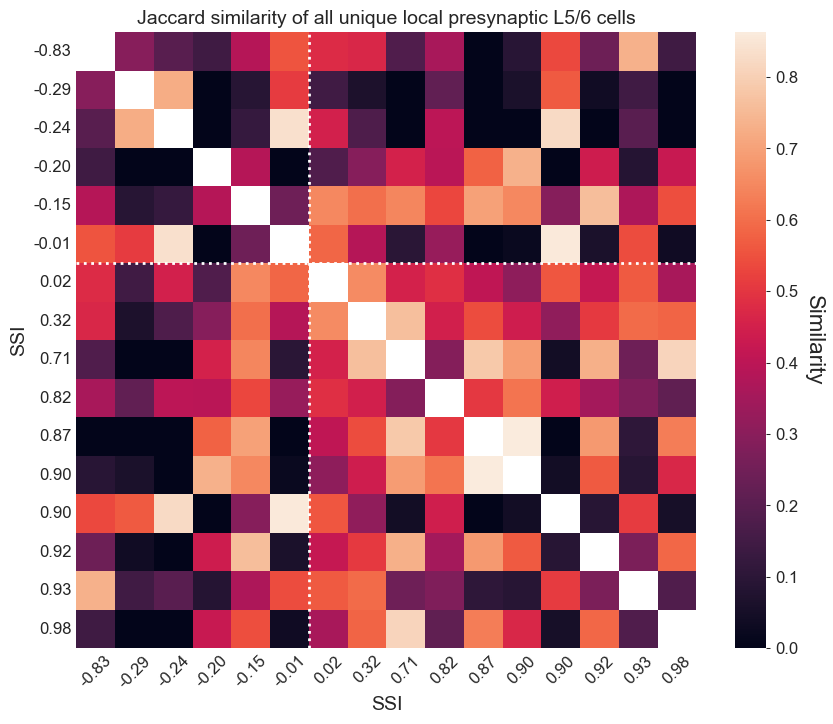

In [194]:
coreg_responsive.sort_values("ssi", inplace=True) # sorted in increasing order of SSI
root_ids = coreg_responsive.pt_root_id.values

similarity_matrix = np.empty((len(root_ids), len(root_ids)), dtype=float)
similarity_matrix[:] = np.nan
similarity_matrix_anno = np.empty((len(root_ids), len(root_ids)), dtype=object)
similarity_matrix_anno[:] = ""

syn_df = all_den_syn_local_input
# syn_df = all_den_syn[~all_den_syn.soma_soma_dist.isna()]

for i, root_id_i in enumerate(root_ids):
    similarity_matrix[i, i] = np.nan
    syn_i = syn_df[syn_df.post_pt_root_id == root_id_i]
    presyn_root_ids_i = syn_i.pre_pt_root_id.values

    for j in range(i+1, len(root_ids)):
        root_id_j = root_ids[j]
        syn_j = syn_df[syn_df.post_pt_root_id == root_id_j]
        presyn_root_ids_j = syn_j.pre_pt_root_id.values

        # sim = np.count_nonzero(np.isin(presyn_root_ids_i, presyn_root_ids_j))
        # sim = jaccard_similarity(presyn_root_ids_i, presyn_root_ids_j)
        # sim = jaccard_similarity(presyn_root_ids_i, presyn_root_ids_j, u=inh_root_ids)
        # sim = jaccard_similarity(presyn_root_ids_i, presyn_root_ids_j, u=mc_root_ids)
        # sim = jaccard_similarity(presyn_root_ids_i, presyn_root_ids_j, u=bc_root_ids)
        # sim = jaccard_similarity(presyn_root_ids_i, presyn_root_ids_j, u=pyc_root_ids)
        # sim = jaccard_similarity(presyn_root_ids_i, presyn_root_ids_j, u=l23_pre_root_ids)
        # sim = jaccard_similarity(presyn_root_ids_i, presyn_root_ids_j, u=l4_pre_root_ids)
        # sim = jaccard_similarity(presyn_root_ids_i, presyn_root_ids_j, u=l56_pre_root_ids)
        sim = shared_conn_weight(syn_i, syn_j, u=mc_root_ids)
        
        anno = f"{len(presyn_root_ids_i)}\n{len(presyn_root_ids_j)}"
        similarity_matrix[i, j] = sim
        similarity_matrix[j, i] = sim
        # similarity_matrix_anno[i, j] = anno
        # similarity_matrix_anno[j, i] = anno

fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(similarity_matrix, annot=similarity_matrix_anno, fmt="", annot_kws=dict(fontsize=9), vmin=0)
cbar = ax.collections[0].colorbar
cbar.set_label("Similarity", fontsize=16, rotation=270, va="bottom")

# ax.set_title("Jaccard similarity of all unique presynaptic cells with soma")
# ax.set_title("Jaccard similarity of all unique local presynaptic cells")
# ax.set_title("Jaccard similarity of all unique local presynaptic inhibitory cells")
# ax.set_title("Jaccard similarity of all unique local presynaptic Martinotti cells")
# ax.set_title("Jaccard similarity of all unique local presynaptic pyramidal cells")
# ax.set_title("Jaccard similarity of all unique local presynaptic L2/3 cells")
# ax.set_title("Jaccard similarity of all unique local presynaptic L4 cells")
ax.set_title("Jaccard similarity of all unique local presynaptic L5/6 cells")

ssi_values = coreg_responsive.ssi.values
tick_labels = [f"{ssi:.2f}" for ssi in ssi_values]
ax.set_xlabel("SSI")
ax.set_ylabel("SSI")
ax.set_xticklabels(tick_labels, rotation=45)
ax.set_yticklabels(tick_labels, rotation=0)
ax.tick_params(length=0) # no tick lines


ssi_sign_switch = np.argmax(ssi_values > 0)
plt.axhline(ssi_sign_switch, color="white", linewidth=2, linestyle="dotted")
plt.axvline(ssi_sign_switch, color="white", linewidth=2, linestyle="dotted")

# topx = ax.secondary_xaxis("top")
# topx.set_ticks(ticks=np.arange(len(root_ids))+0.5, labels=tick_labels)
# topx.set_frame_on(False)
# topx.tick_params(length=0)
# topx.set_xlabel("Number of presynaptic cells")

# Do the same for directions

array([-0.82873565, -0.29011783, -0.24062905, -0.20341802, -0.15352286,
       -0.0131317 ,  0.02199955,  0.32355949,  0.7071619 ,  0.81695116,
        0.86984003,  0.90291584,  0.90473151,  0.91839612,  0.9283883 ,
        0.97588295])

/var/folders/8l/944wpj6s7sq8gcv57wcd3q6h0000gn/T/ipykernel_94671/32044240.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  coreg_responsive.sort_values(metric, inplace=True) # sorted in increasing order of SSI


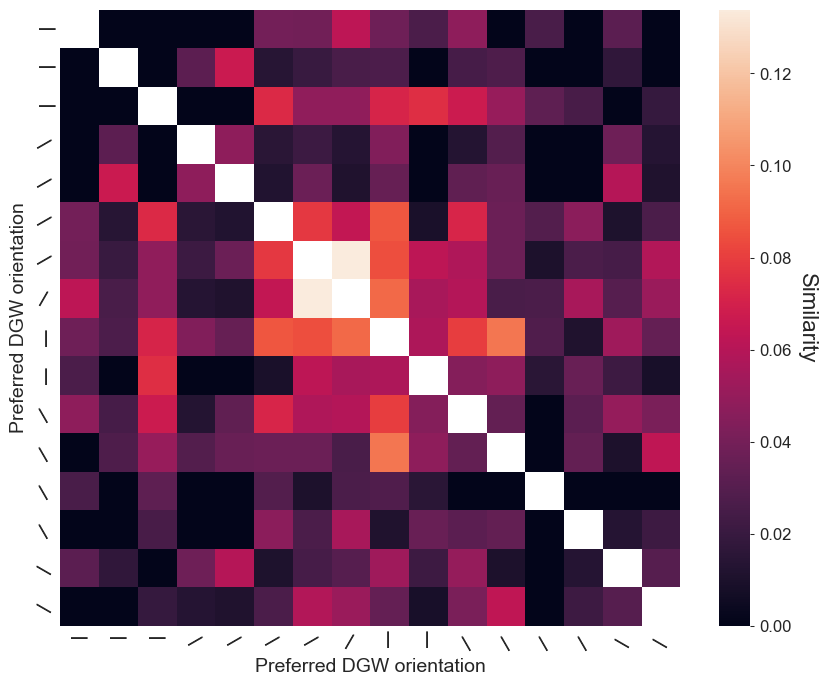

In [217]:
metric, metric_name, tick_labels, tick_label_angles = [
    ("ssi", "SSI", [f"{ssi:.2f}" for ssi in coreg_responsive.ssi.sort_values().values], coreg_responsive.ssi.sort_values().values),
    ("dgw_pref_ori", "Preferred DGW orientation", "—", coreg_responsive.dgw_pref_ori.sort_values().values),
    ("dgw_pref_dir", "Preferred DGW direction", "→", coreg_responsive.dgw_pref_dir.sort_values().values)
][0]
coreg_responsive.sort_values(metric, inplace=True) # sorted in increasing order of metric
root_ids = coreg_responsive.pt_root_id.values

similarity_matrix = np.empty((len(root_ids), len(root_ids)), dtype=float)
similarity_matrix[:] = np.nan
similarity_matrix_anno = np.empty((len(root_ids), len(root_ids)), dtype=object)
similarity_matrix_anno[:] = ""

# syn_df = all_den_syn_local_input
syn_df = all_den_syn[~all_den_syn.soma_soma_dist.isna()]

for i, root_id_i in enumerate(root_ids):
    similarity_matrix[i, i] = np.nan
    syn_i = syn_df[syn_df.post_pt_root_id == root_id_i]
    presyn_root_ids_i = syn_i.pre_pt_root_id.values

    for j in range(i+1, len(root_ids)):
        root_id_j = root_ids[j]
        syn_j = syn_df[syn_df.post_pt_root_id == root_id_j]
        presyn_root_ids_j = syn_j.pre_pt_root_id.values

        # sim = np.count_nonzero(np.isin(presyn_root_ids_i, presyn_root_ids_j))
        # sim = jaccard_similarity(presyn_root_ids_i, presyn_root_ids_j)
        # sim = jaccard_similarity(presyn_root_ids_i, presyn_root_ids_j, u=inh_root_ids)
        # sim = jaccard_similarity(presyn_root_ids_i, presyn_root_ids_j, u=mc_root_ids)
        # sim = jaccard_similarity(presyn_root_ids_i, presyn_root_ids_j, u=bc_root_ids)
        # sim = jaccard_similarity(presyn_root_ids_i, presyn_root_ids_j, u=pyc_root_ids)
        sim = jaccard_similarity(presyn_root_ids_i, presyn_root_ids_j, u=l23_pre_root_ids)
        # sim = jaccard_similarity(presyn_root_ids_i, presyn_root_ids_j, u=l4_pre_root_ids)
        # sim = jaccard_similarity(presyn_root_ids_i, presyn_root_ids_j, u=l56_pre_root_ids)
        # sim = shared_conn_weight(syn_i, syn_j, u=mc_root_ids)
        
        anno = f"{len(presyn_root_ids_i)}\n{len(presyn_root_ids_j)}"
        similarity_matrix[i, j] = sim
        similarity_matrix[j, i] = sim
        # similarity_matrix_anno[i, j] = anno
        # similarity_matrix_anno[j, i] = anno

fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(similarity_matrix, annot=similarity_matrix_anno, fmt="", annot_kws=dict(fontsize=9), vmin=0)
cbar = ax.collections[0].colorbar
cbar.set_label("Similarity", fontsize=16, rotation=270, va="bottom")

# ax.set_title("Jaccard similarity of all unique presynaptic cells with soma")
# ax.set_title("Jaccard similarity of all unique local presynaptic cells")
# ax.set_title("Jaccard similarity of all unique local presynaptic inhibitory cells")
# ax.set_title("Jaccard similarity of all unique local presynaptic Martinotti cells")
# ax.set_title("Jaccard similarity of all unique local presynaptic pyramidal cells")
# ax.set_title("Jaccard similarity of all unique local presynaptic L2/3 cells")
# ax.set_title("Jaccard similarity of all unique local presynaptic L4 cells")
# ax.set_title("Jaccard similarity of all unique local presynaptic L5/6 cells")

ax.set_xlabel(metric_name)
ax.set_ylabel(metric_name)
if type(tick_labels) is str:
    tick_labels = [tick_labels for _ in range(len(root_ids))]
ax.set_xticklabels(tick_labels, fontweight="bold")
ax.set_yticklabels(tick_labels, fontweight="bold")
ax.tick_params(length=0) # no tick lines

for ticks in (ax.get_xticklabels(), ax.get_yticklabels()):
    for tick, angle in zip(ticks, coreg_responsive[metric]):
        tick.set_rotation(angle)

# ssi_sign_switch = np.argmax(ssi_values > 0)
# plt.axhline(ssi_sign_switch, color="white", linewidth=2, linestyle="dotted")
# plt.axvline(ssi_sign_switch, color="white", linewidth=2, linestyle="dotted")

# topx = ax.secondary_xaxis("top")
# topx.set_ticks(ticks=np.arange(len(root_ids))+0.5, labels=tick_labels)
# topx.set_frame_on(False)
# topx.tick_params(length=0)
# topx.set_xlabel("Number of presynaptic cells")

In [203]:
coreg_responsive.dgw_pref_dir.values

array([180., 180.,   0.,  30.,  30.,  30.,  30., 240.,  90., 270., 300.,
       300., 120., 300., 150., 150.])